In [67]:
import numpy as np
import pandas as pd
import os

#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [68]:
import contextlib
import functools
import time

@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)

def make_val_and_grad_fn(value_fn):
  @functools.wraps(value_fn)
  def val_and_grad(x):
    return tfp.math.value_and_gradient(value_fn, x)
  return val_and_grad

def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

In [69]:
data = pd.read_csv("./data/data7.csv")
data.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [70]:
data_w_cnt = data.copy()
data_w_cnt["cnt"] = np.zeros(data_w_cnt.shape[0], dtype=np.int32)
print(data_w_cnt.head())
for x in np.unique(data_w_cnt.x):
    u, cnt = np.unique(data_w_cnt[data_w_cnt.x == x].y, return_counts=True)
    print("x:", x)
    print(u, cnt)
    for i in range(len(cnt)):
        mask = (data_w_cnt.x == x) & (data_w_cnt.y == u[i])
        data_w_cnt.loc[mask, "cnt"] = cnt[i]
data_w_cnt.astype({"cnt": "float64"})
print(data_w_cnt.head())

   N  y  x  id  cnt
0  8  0  2   1    0
1  8  1  2   2    0
2  8  2  2   3    0
3  8  4  2   4    0
4  8  1  2   5    0
x: 2
[0 1 2 3 4 5 6 7] [8 4 1 2 1 1 1 2]
x: 3
[0 1 2 3 4 5 6 8] [8 2 3 1 1 2 1 2]
x: 4
[0 1 2 3 4 5 6 7 8] [3 1 4 2 1 1 2 3 3]
x: 5
[0 1 2 3 4 5 6 7 8] [1 1 2 2 2 1 1 5 5]
x: 6
[0 1 2 3 5 6 7 8] [2 2 1 2 1 1 2 9]
   N  y  x  id  cnt
0  8  0  2   1    8
1  8  1  2   2    4
2  8  2  2   3    1
3  8  4  2   4    1
4  8  1  2   5    4


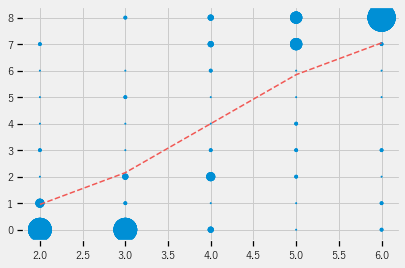

In [71]:
def logistic(z):
    return 1. / (1. + tf.exp(-z))
dist = tfd.Binomial(total_count=8, probs=logistic(-4. + 1. * data_w_cnt.x))

plt.scatter(data_w_cnt.x, data_w_cnt.y, s=data_w_cnt.cnt ** 3)
plt.plot(data_w_cnt.x, dist.mean(), "--", c=TFColor[0])
plt.show()

In [72]:
def logistic(z):
    return 1. / (1. + tf.exp(-z))

def linear_predictor(beta_1, beta_2, x):
    return beta_1 + beta_2 * x

@make_val_and_grad_fn
def logl(beta):
    q = logistic(linear_predictor(beta[0], beta[1], data_w_cnt.x))
    dist = tfd.Binomial(total_count=8, probs=q)
    logl = -tf.reduce_sum(dist.log_prob(data_w_cnt.y))
    return logl

dim = 2

start = np.random.randn(dim)
tolerance = 1e-10

@tf.function
def logl_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(
        logl,
        initial_position=tf.constant(start, dtype=tf.float32),
        tolerance=tf.constant(tolerance, dtype=tf.float32)
    )
results_f_c = run(logl_with_lbfgs)

print('L-BFGS Results')
print("From:", start)
print('Converged:', results_f_c.converged)
print('Location of the minimum:', results_f_c.position) 
print('Number of iterations:', results_f_c.num_iterations)

Evaluation took: 0.141621 seconds
L-BFGS Results
From: [-0.31850286  2.14749412]
Converged: True
Location of the minimum: [-2.1487117  0.5103716]
Number of iterations: 6


3.7857548702903623


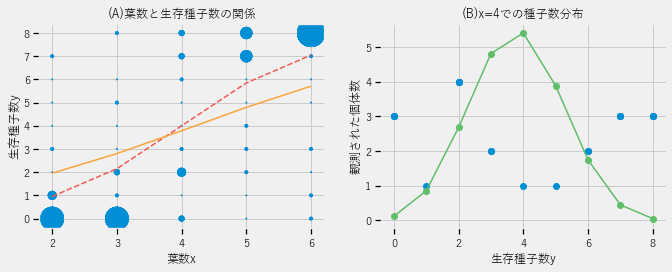

In [73]:
prediction = tfd.Binomial(
    total_count=8, 
    probs=logistic(linear_predictor(results_f_c.position[0], results_f_c.position[1], data_w_cnt.x))
).mean()

data_x_4 = data_w_cnt[data_w_cnt.x == 4]
pdf_4 = tfd.Binomial(
    total_count=8, 
    probs=logistic(linear_predictor(results_f_c.position[0], results_f_c.position[1], 4))
).prob(np.arange(0, 9)) * 20

print(
    tfd.Binomial(
        total_count=8, 
        probs=logistic(linear_predictor(results_f_c.position[0], results_f_c.position[1], 4))
    ).mean().numpy()
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
ax = axes[0]
ax.scatter(data_w_cnt.x, data_w_cnt.y, s=data_w_cnt.cnt ** 3)
ax.plot(data_w_cnt.x, dist.mean(), "--", c=TFColor[0])
ax.plot(data_w_cnt.x, prediction, "-", c=TFColor[1])
ax.set_xlabel("葉数x")
ax.set_ylabel("生存種子数y")
ax.set_title("(A)葉数と生存種子数の関係")
ax = axes[1]
ax.scatter(data_x_4.y, data_x_4.cnt)
ax.plot(np.arange(0, 9), pdf_4, c=TFColor[2], marker="o")
ax.set_xlabel("生存種子数y")
ax.set_ylabel("観測された個体数")
ax.set_title("(B)x=4での種子数分布")
plt.show()

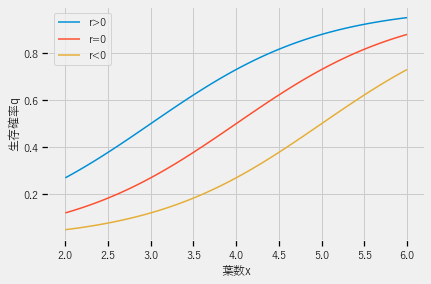

In [75]:
def linear_predictor(beta_1, beta_2, x, r):
    return beta_1 + beta_2 * x + r

xx = np.linspace(2, 6, 100)
beta_1 = -4
beta_2 = 1
r = [1., 0., -1.]
q = np.stack((
  logistic(linear_predictor(beta_1, beta_2, xx, r[0])),
  logistic(linear_predictor(beta_1, beta_2, xx, r[1])),
  logistic(linear_predictor(beta_1, beta_2, xx, r[2]))  
))

plt.plot(xx, q[0], label="r>0")
plt.plot(xx, q[1], label="r=0")
plt.plot(xx, q[2], label="r<0")
plt.legend()
plt.xlabel("葉数x")
plt.ylabel("生存確率q")
plt.show()


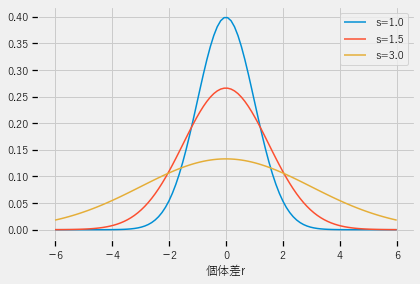

In [87]:
xx = np.linspace(-6, 6, 100)

plt.plot(xx, tfd.Normal(loc=0., scale=1.0).prob(xx), label="s=%.1f" %1.0)
plt.plot(xx, tfd.Normal(loc=0., scale=1.5).prob(xx), label="s=%.1f" %1.5)
plt.plot(xx, tfd.Normal(loc=0., scale=3.0).prob(xx), label="s=%.1f" %3.0)
plt.legend()
plt.xlabel("個体差r")
plt.show()

# 7.4

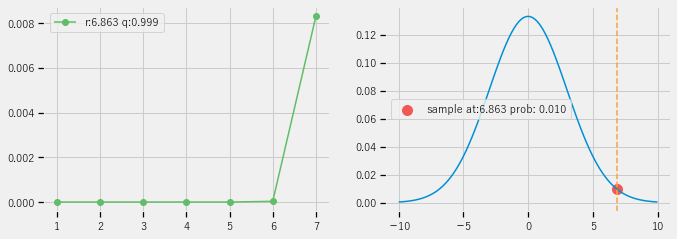

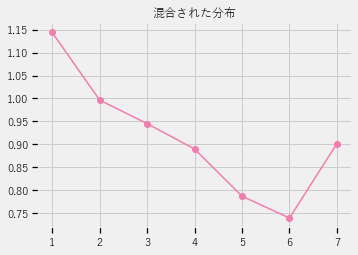

In [181]:
def linear_predictor(beta, r):
    return beta + r

N = 8
n_sample = 100

num_leaf = np.arange(1, 8)
beta = 0
r_dist = tfd.Normal(loc=0., scale=3.)

r_dist_prob_plot_xx = np.linspace(-10, 10, n_sample)
r_dist_prob_plot = r_dist.prob(r_dist_prob_plot_xx)

samples_of_r = r_dist.sample(n_sample) # sample noise value
probs_of_r_sample = r_dist.prob(samples_of_r) # probs of sampled noise value

y_dist_q = logistic(linear_predictor(beta, samples_of_r))
y_dist = tfd.Binomial(total_count=N, probs=y_dist_q)

def draw_r_normal(ax, sampled_r, r_prob):
    ax.plot(r_dist_prob_plot_xx, r_dist_prob_plot)
    ax.axvline(x=sampled_r, color=TFColor[1], linestyle="--")
    ax.scatter(sampled_r, r_prob, color=TFColor[0], s=100., label="sample at:%.3f prob: %.3f" %(sampled_r, r_prob))
    ax.legend()

def draw_y_binomial(ax, bin_prob, sampled_r, q_val):
    ax.plot(
        num_leaf, bin_prob, 
        marker="o", color=TFColor[2],
        label="r:%.3f q:%.3f" %(sampled_r, q_val)
    )
    ax.legend()

prob_of_y = y_dist[0].prob(num_leaf)
probs_of_r = probs_of_r_sample[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
draw_y_binomial(axes[0], prob_of_y, samples_of_r[0], y_dist_q[0])
draw_r_normal(axes[1], samples_of_r[0], probs_of_r)
plt.show()

# mix
mixed_prob = 0.
for i in range(n_sample):
    y_prob = y_dist[i].prob(num_leaf)
    r_prob = probs_of_r_sample[i]
    yi_x_ri = y_prob * r_prob
    mixed_prob = mixed_prob + yi_x_ri

fig, axes = plt.subplots(1, 1, figsize=(5, 3.5))
axes.plot(num_leaf, mixed_prob, color=TFColor[4], marker="o")
axes.set_title("混合された分布")
plt.show()

In [184]:
# def logistic(z):
#     return 1. / (1. + tf.exp(-z))

# def linear_predictor(beta_1, beta_2, x, r):
#     return beta_1 + beta_2 * x + r

# @make_val_and_grad_fn
# def logl(beta):
#     n_sample = 100
#     logl = 0.
#     for i in range(n_sample):
#         r_dist = tfd.Normal(loc=0., scale=beta[2])
#         r_sample = r_dist.sample(1)
#         q = logistic(linear_predictor(beta[0], beta[1], data_w_cnt.x, r_sample))
#         dist = tfd.Binomial(total_count=8, probs=q)
#         this_logl = tf.reduce_sum(dist.log_prob(data_w_cnt.y) + r_dist.log_prob(r_sample))
#         logl = logl + this_logl
#     return logl * -1.0

# dim = 3

# start = np.random.randn(dim)
# tolerance = 1e-10

# @tf.function
# def logl_with_lbfgs():
#     return tfp.optimizer.lbfgs_minimize(
#         logl,
#         initial_position=tf.constant(start, dtype=tf.float32),
#         tolerance=tf.constant(tolerance, dtype=tf.float32)
#     )
# results_f_c = run(logl_with_lbfgs)

# print('L-BFGS Results')
# print("From:", start)
# print('Converged:', results_f_c.converged)
# print('Location of the minimum:', results_f_c.position) 
# print('Number of iterations:', results_f_c.num_iterations)